In [1]:
import os
import os.path as osp
import pandas as pd
import numpy as np
from snorkel import SnorkelSession
from snorkel.learning.pytorch import LSTM
from matplotlib import pyplot as plt
import plotnine as pn
import dotenv
dotenv.load_dotenv('../env.sh')
%matplotlib inline
%run ../src/supervision.py
session = SnorkelSession()

In [2]:
classes = get_candidate_classes()
candidate_class = classes.inducing_cytokine
X = session.query(candidate_class.subclass).filter(candidate_class.subclass.split == 0).all()
len(X)

11817

In [3]:
lstm = LSTM()
lstm.load('lstm_' + candidate_class.field, '/tmp/lstm')

[LSTM] Loaded model <lstm_inducing_cytokine>


In [4]:
Y = lstm.marginals(X)
Y.shape

/Users/eczech/anaconda3/envs/snorkel/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


(11817,)

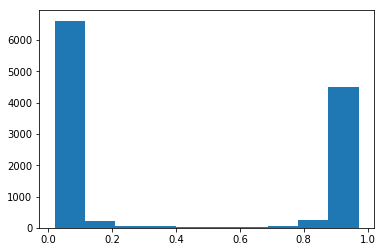

In [5]:
plt.hist(Y)
None

In [8]:
# from snorkel import viewer
# idx = np.argsort(Y)
# idx = idx[-100:]
# viewer.SentenceNgramViewer(
#     candidates=[X[i] for i in idx], 
#     session=session
# )

In [6]:
df_ck = pd.read_csv(osp.join(os.environ['META_DATA_DIR'], 'cytokines.csv'))
df_ct = pd.read_csv(osp.join(os.environ['META_DATA_DIR'], 'cell_types.csv'))
m_ct, m_ck = df_ct.set_index('prefid')['lbl'].to_dict(), df_ck.set_index('prefid')['lbl'].to_dict()

In [7]:
assert len(X) == len(Y)
def to_record(c, i):
    typs = candidate_class.entity_types
    m1, m2 = {}, m_ct
    if typs[0] == ENT_TYP_CK.lower():
        m1 = m_ck
    ent1_cid = getattr(c, typs[0] + '_cid')
    ent2_cid = getattr(c, typs[1] + '_cid')
    return {
        'type': candidate_class.field, 
        'doc_id': c.get_parent().get_parent().name, 
        'candidate_id': c.id, 
        'ent1_text': getattr(c, typs[0]).get_span(),
        'ent1_lbl': m1.get(ent1_cid.split(':')[1], None),
        'ent1_cid': ent1_cid, 
        'ent2_text': getattr(c, typs[1]).get_span(),
        'ent2_lbl': m2.get(ent2_cid.split(':')[1], None),
        'ent2_cid': ent2_cid,
        'prob': Y[i]
    }

df = pd.DataFrame([to_record(c, i) for i, c in enumerate(X)])
df.head()

,candidate_id,doc_id,ent1_cid,ent1_lbl,ent1_text,ent2_cid,ent2_lbl,ent2_text,prob,type
0,1,PMC3591132,CKC645FE6112316D36:CK64C4AB510CA1ACA7,CD154,CD40L,CTA435D07EA4694572:CTFE4015328B70D553,Thymocyte,thymocytes,0.919962,inducing_cytokine
1,2,PMC3591132,CKC645FE6112316D36:CK64C4AB510CA1ACA7,CD154,CD40L,CT7AC25DF3B0DDF9BE:CTB574584AD019ABB8,Treg,Tregs,0.917673,inducing_cytokine
2,3,PMC6131392,CKC5CC1A269C01EC48:CKC5CC1A269C01EC48,IL-10,IL-10,CTE9F6070561C95355:CTE9F6070561C95355,Tfh,TFH,0.935218,inducing_cytokine
3,4,PMC6131392,CKB1327E1355BFD9DD:CK128EC732B281BF60,IFN-γ,interferon-γ,CTE9F6070561C95355:CTE9F6070561C95355,Tfh,TFH,0.033429,inducing_cytokine
4,5,PMC6131392,CK128EC732B281BF60:CK128EC732B281BF60,IFN-γ,IFN-γ,CTE9F6070561C95355:CTE9F6070561C95355,Tfh,TFH,0.039075,inducing_cytokine


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11817 entries, 0 to 11816
Data columns (total 10 columns):
candidate_id    11817 non-null int64
doc_id          11817 non-null object
ent1_cid        11817 non-null object
ent1_lbl        11817 non-null object
ent1_text       11817 non-null object
ent2_cid        11817 non-null object
ent2_lbl        11817 non-null object
ent2_text       11817 non-null object
prob            11817 non-null float64
type            11817 non-null object
dtypes: float64(1), int64(1), object(8)
memory usage: 923.3+ KB


In [1]:
#df.groupby(['ent2_lbl', 'ent1_lbl'])['prob'].describe().sort_values('mean')

In [11]:
df['ent2_lbl'].value_counts().sort_values().tail()

Th       633
Treg    1601
Th2     1873
Th1     1971
Th17    2843
Name: ent2_lbl, dtype: int64

In [12]:
df['ent1_lbl'].value_counts().sort_values().tail()

IL-2      771
IL-10     962
IL-4     1281
TGF-β    1337
IFN-γ    1434
Name: ent1_lbl, dtype: int64

In [40]:
# (
#     df
#     .groupby(['ent2_lbl', 'ent1_lbl'])['prob'].agg(['count', 'mean']).reset_index()
#     .query('count > 10')
#     .sort_values('count', ascending=False)
#     .query('ent2_lbl == "Th1"')
#     .head(25)
# )

In [37]:
(
    df.query('prob > .5')
    .groupby(['ent2_lbl', 'ent1_lbl'])['prob'].agg(['count', 'mean']).reset_index()
    .query('count > 10')
    .sort_values('count', ascending=False)
    .query('ent2_lbl == "Th9"')
    .head(25)
)

,ent2_lbl,ent1_lbl,count,mean
373,Th9,IL-9,33,0.909404
370,Th9,IL-33,28,0.928932
371,Th9,IL-4,24,0.905726


In [ ]:
(
    pn.ggplot(df, pn.aes(x='ent1_lbl', y='prob')) + 
    pn.geom_boxplot() +
    pn.facet_wrap('~ ent2_lbl')
)

/Users/eczech/anaconda3/envs/snorkel/lib/python3.6/site-packages/plotnine/stats/stat.py:310: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/Users/eczech/anaconda3/envs/snorkel/lib/python3.6/site-packages/plotnine/utils.py:629: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat(lst, axis=axis, ignore_index=True)


KeyboardInterrupt: 

ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.


### Export Candidates to BRAT

In [41]:
%run ../src/brat.py
collection_dir = osp.join(os.environ['REPO_DATA_DIR'], 'brat', 'viz', 'train_01')
corpus_docs_dir = osp.join(os.environ['DATA_DIR'], 'articles', 'corpus', 'corpus_00', 'links')
collection_dir, corpus_docs_dir

('/Users/eczech/repos/hammer/t-cell-relation-extraction/pm_subtype_protein_relations/data/brat/viz/train_01',
 '/Users/eczech/data/research/hammer/nlp/20190311-pubmed-tcell-relation/articles/corpus/corpus_00/links')

<Figure size 432x288 with 0 Axes>

In [42]:
def relation_type_fn(c, i, ents):
    proba = Y[i] 
    if proba < .2:
        return c.type + '_low'
    if proba < .8:
        return c.type + '_mid'
    return c.type + '_high'

def text_loader_fn(doc_id):
    with open(osp.join(corpus_docs_dir, doc_id + '.txt')) as fd:
        return fd.read()

In [44]:
bcol = snorkel_candidates_to_brat_collection(
    X, candidate_class.subclass, text_loader_fn, relation_type_fn=relation_type_fn)

In [45]:
bcol.export(collection_dir, styles={
    'inducing_cytokine_low': 'color:red',
    'inducing_cytokine_mid': 'color:orange',
    'inducing_cytokine_high': 'color:green'
}, include_entity_text=False)